In [37]:
import numpy as np
from pathlib import Path
from PIL import Image
import cv2
import scipy.stats 
import matplotlib.pyplot as plt
from pillow_heif import open_heif

class HENormalizer:
    def fit(self, target):
        pass

    def normalize(self, I, **kwargs):
        raise Exception('Abstract method')

"""
Source code adapted from: https://github.com/schaugf/HEnorm_python
Original implementation: https://github.com/mitkovetta/staining-normalization
"""
class NumpyMacenkoNormalizer(HENormalizer):
    def __init__(self):
        super().__init__()

        self.HERef = np.array([[0.5626, 0.2159],
                          [0.7201, 0.8012],
                          [0.4062, 0.5581]])
        self.maxCRef = np.array([1.9705, 1.0308])

    def __convert_rgb2od(self, I, Io=240, beta=0.15):
        # calculate optical density
        OD = -np.log((I.astype(float)+1)/Io)

        # remove transparent pixels
        ODhat = OD[~np.any(OD < beta, axis=1)]

        return OD, ODhat

    def __find_HE(self, ODhat, eigvecs, alpha):
        #project on the plane spanned by the eigenvectors corresponding to the two
        # largest eigenvalues
        That = ODhat.dot(eigvecs[:,1:3])

        phi = np.arctan2(That[:,1],That[:,0])

        minPhi = np.percentile(phi, alpha)
        maxPhi = np.percentile(phi, 100-alpha)

        vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
        vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)

        # a heuristic to make the vector corresponding to hematoxylin first and the
        # one corresponding to eosin second
        if vMin[0] > vMax[0]:
            HE = np.array((vMin[:,0], vMax[:,0])).T
        else:
            HE = np.array((vMax[:,0], vMin[:,0])).T

        return HE

    def __find_concentration(self, OD, HE):
        # rows correspond to channels (RGB), columns to OD values
        Y = np.reshape(OD, (-1, 3)).T

        # determine concentrations of the individual stains
        C = np.linalg.lstsq(HE, Y, rcond=None)[0]

        return C

    def __compute_matrices(self, I, Io, alpha, beta):
        I = I.reshape((-1,3))

        OD, ODhat = self.__convert_rgb2od(I, Io=Io, beta=beta)

        # compute eigenvectors
        _, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

        HE = self.__find_HE(ODhat, eigvecs, alpha)

        C = self.__find_concentration(OD, HE)

        # normalize stain concentrations
        maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])

        return HE, C, maxC

    def fit(self, I, Io=240, alpha=1, beta=0.15):
        HE, _, maxC = self.__compute_matrices(I, Io, alpha, beta)

        self.HERef = HE
        self.maxCRef = maxC

    def normalize(self, I, Io=240, alpha=1, beta=0.15, stains=True):
        ''' Normalize staining appearence of H&E stained images

        Example use:
            see test.py

        Input:
            I: RGB input image
            Io: (optional) transmitted light intensity

        Output:
            Inorm: normalized image
            H: hematoxylin image
            E: eosin image

        Reference:
            A method for normalizing histology slides for quantitative analysis. M.
            Macenko et al., ISBI 2009
        '''
        h, w, c = I.shape
        I = I.reshape((-1,3))

        HE, C, maxC = self.__compute_matrices(I, Io, alpha, beta)

        maxC = np.divide(maxC, self.maxCRef)
        C2 = np.divide(C, maxC[:, np.newaxis])

        # recreate the image using reference mixing matrix
        Inorm = np.multiply(Io, np.exp(-self.HERef.dot(C2)))
        Inorm[Inorm > 255] = 255
        Inorm = np.reshape(Inorm.T, (h, w, c)).astype(np.uint8)


        H, E = None, None

        if stains:
            # unmix hematoxylin and eosin
            H = np.multiply(Io, np.exp(np.expand_dims(-self.HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
            H[H > 255] = 255
            H = np.reshape(H.T, (h, w, c)).astype(np.uint8)

            E = np.multiply(Io, np.exp(np.expand_dims(-self.HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
            E[E > 255] = 255
            E = np.reshape(E.T, (h, w, c)).astype(np.uint8)

        return Inorm, H, E
    
def read_image(path, scale=1 / 4):
    try:
        if Path(path).suffix.lower() == ".heic":
            img = open_heif(path, convert_hdr_to_8bit=True)
        else:
            img = Image.open(path)
        rgb = np.asarray(img)
        H, W = rgb.shape[:-1]
        new_H = int(H * scale)
        new_W = int(W * scale)
    except:
        print(path)
        raise
    return cv2.resize(rgb, (new_W, new_H))

<BarContainer object of 256 artists>

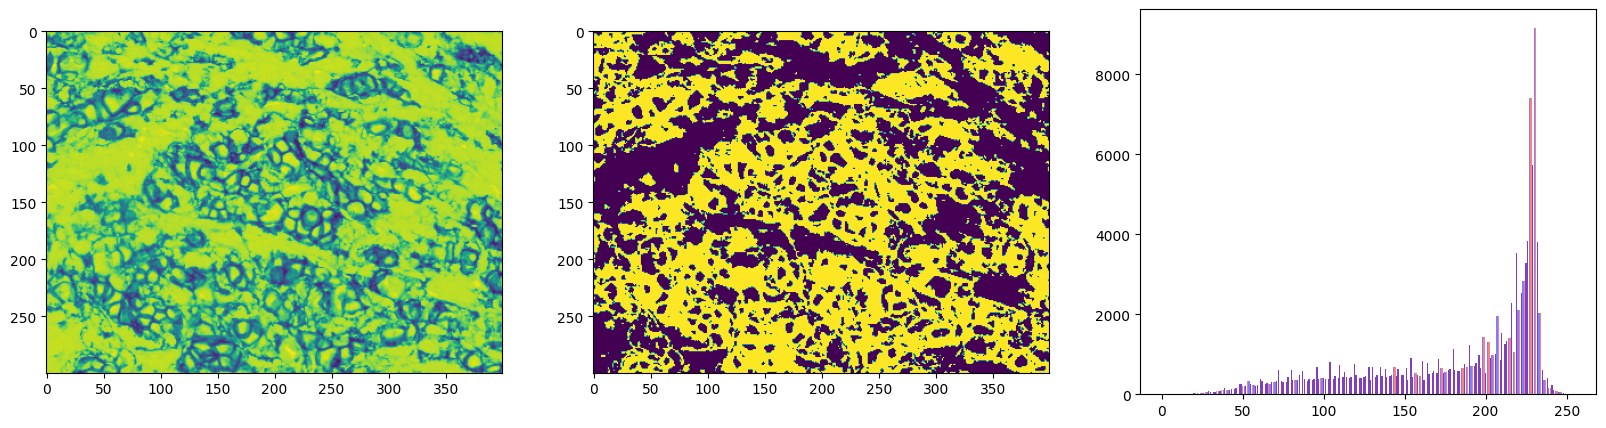

In [103]:
path = "/home/surayuth/her2/Data_Chula/HER2 2+ DISH+ case 08/ 8 July Pos Dish (64).JPG"
#path = "/home/surayuth/her2/Data_Chula/28-08-23 HER2 2+ D+ Case 4/Case 04 (1).JPG"
normalizer = NumpyMacenkoNormalizer()
img = read_image(path)
normalizer.fit(img)
Inorm, H, E = normalizer.normalize(img)
gray = cv2.cvtColor(E, cv2.COLOR_RGB2GRAY)
norm_gray = np.round((gray - gray.min()) / (gray.max() - gray.min()) * 255).astype(np.uint8)
mode = scipy.stats.mode(norm_gray.reshape(-1)).mode
width_mode = 20

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(norm_gray)
ax2.imshow(norm_gray < max(mode - width_mode, 0))
ax3.bar(np.arange(256), np.histogram(gray.reshape(-1), bins=256)[0], color=[("red", .5)])
ax3.bar(np.arange(256), np.histogram(norm_gray.reshape(-1), bins=256)[0], color=[("blue", .5)])

In [104]:
mode - mode * (1 - 0.1)

np.float64(23.0)

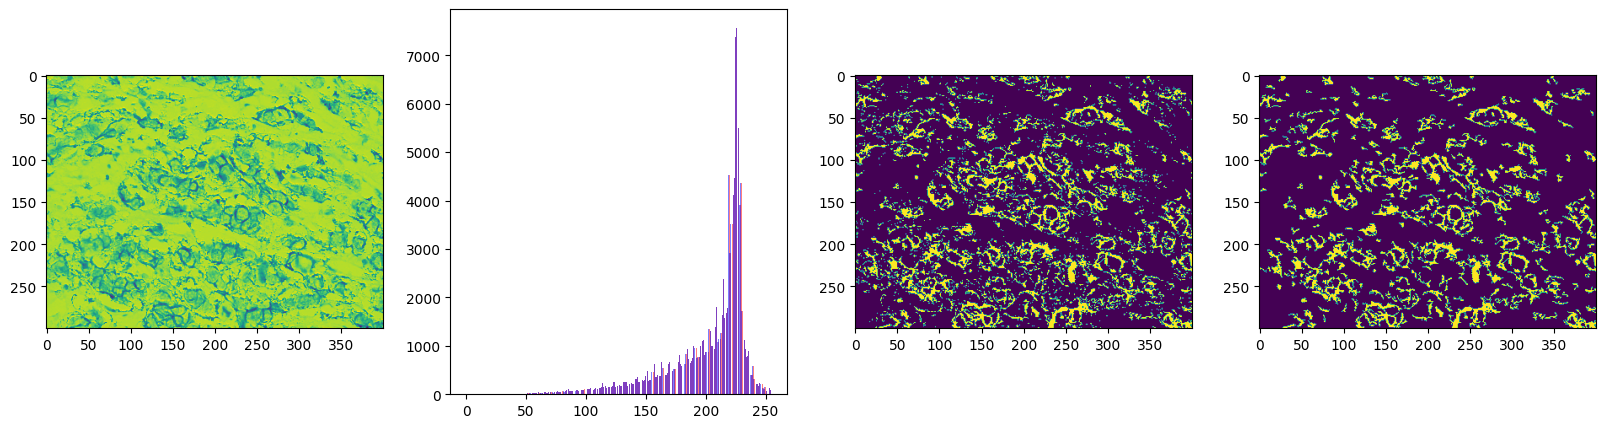

In [106]:
gray = cv2.cvtColor(H, cv2.COLOR_RGB2GRAY)
norm_gray = np.round((gray - gray.min()) / (gray.max() - gray.min()) * 255).astype(np.uint8)
mode = scipy.stats.mode(norm_gray.reshape(-1)).mode
width_mode = 50

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.imshow(norm_gray)
ax3.imshow(norm_gray < max(mode - width_mode, 0))
ax2.bar(np.arange(256), np.histogram(gray.reshape(-1), bins=256)[0], color=[("red", .5)])
ax2.bar(np.arange(256), np.histogram(norm_gray.reshape(-1), bins=256)[0], color=[("blue", .5)])


analysis = cv2.connectedComponentsWithStats(((norm_gray < max(mode - width_mode, 0)) * 255).astype(np.uint8), 
                                            4, 
                                            cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 

h, w = (norm_gray < max(mode - width_mode, 0)).shape
# Initialize a new image to 
# store all the output components 
output = np.zeros((norm_gray < max(mode - width_mode, 0)).shape, dtype="uint8")


# Loop through each component 
count = 0
for i in range(1, totalLabels): 
    area = values[i, cv2.CC_STAT_AREA]   
    if (area > 10) and (area < h * w / 100): 
        count += 1
        # Labels stores all the IDs of the components on the each pixel 
        # It has the same dimension as the threshold 
        # So we'll check the component 
        # then convert it to 255 value to mark it white 
        componentMask = (label_ids == i).astype("uint8") * 255
          
        # Creating the Final output mask 
        output = cv2.bitwise_or(output, componentMask) 
ax4.imshow(output)

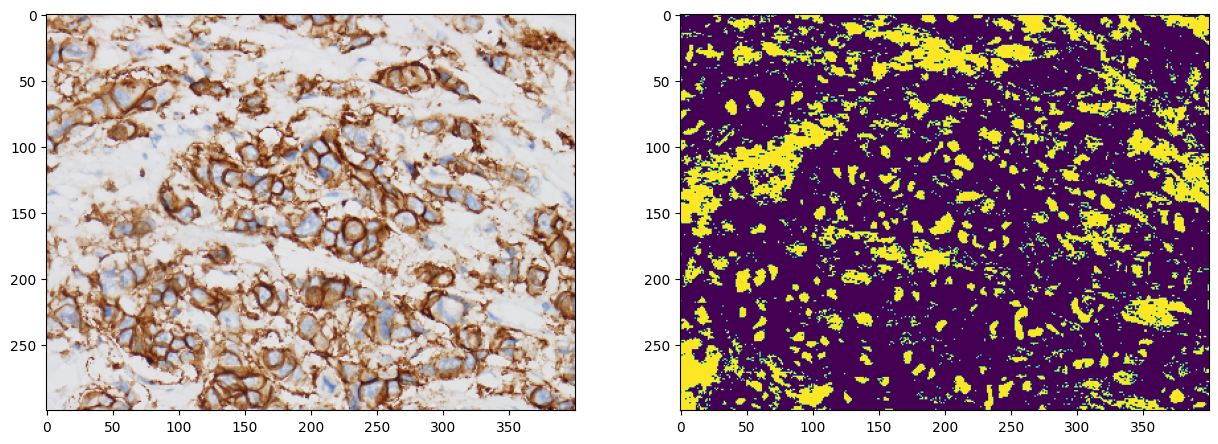

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].imshow(img)
axs[1].imshow(img[:,:,0] < img[:,:,2])